In [ ]:
import pandas as pd
import numpy as np

# Simulating  user data
np.random.seed(42)
n_users = 1000
user_ids = np.arange(1, n_users + 1)



# Simulating  campaign exposure using Binominal distribution
exposed = np.random.binomial(1, 0.5, n_users)

# Simulate engagement metrics

clicks_before = np.random.poisson(1, n_users)

clicks_after = clicks_before + exposed + np.random.poisson(1, n_users)

conversions_before = np.random.binomial(1, 0.1, n_users)

conversions_after = conversions_before + exposed + np.random.binomial(1, 0.1, n_users)

# Create DataFrame
data = pd.DataFrame({
    'user_id': user_ids,
    'exposed': exposed,
    'clicks_before': clicks_before,
    'clicks_after': clicks_after,
    'conversions_before': conversions_before,
    'conversions_after': conversions_after
})

data.head()


,user_id,exposed,clicks_before,clicks_after,conversions_before,conversions_after
0,1,0,0,0,0,0
1,2,1,2,5,0,1
2,3,1,2,4,0,2
3,4,1,1,3,0,1
4,5,0,1,2,0,0


Text(0.5, 1.0, 'Clicks Before')

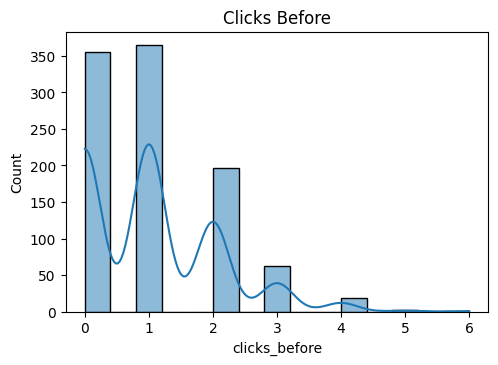

In [ ]:
# let's plot how above disrtubtions looks

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distributions
plt.figure(figsize=(12, 8))

# Clicks Before
plt.subplot(2, 2, 1)
sns.histplot(data['clicks_before'], kde=True)
plt.title('Clicks Before')

Text(0.5, 1.0, 'Clicks After')

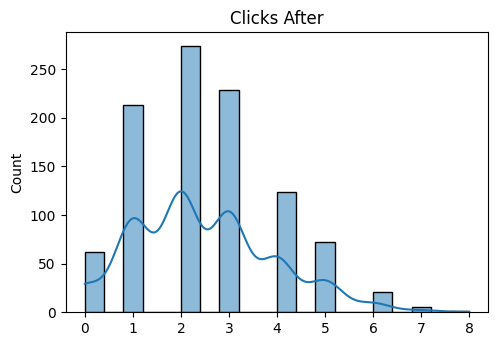

In [ ]:
#clicks after
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
sns.histplot(clicks_after, kde=True)
plt.title('Clicks After')

Text(0.5, 1.0, 'Conversions Before')

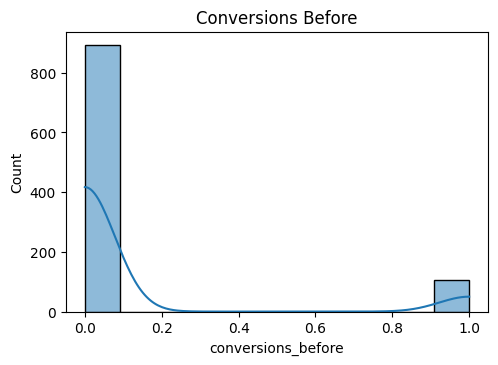

In [ ]:
plt.figure(figsize=(12, 8))

# Conversions before
plt.subplot(2, 2, 1)
sns.histplot(data['conversions_before'], kde=True)
plt.title('Conversions Before')

Text(0.5, 1.0, 'Conversions After')

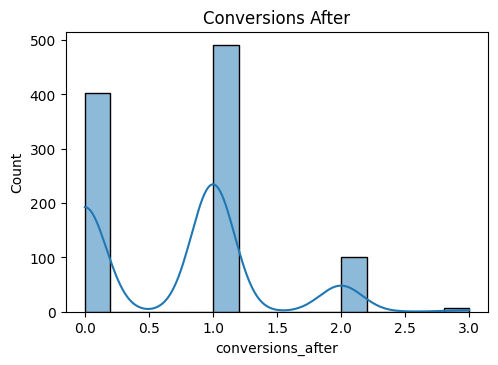

In [ ]:
plt.figure(figsize=(12, 8))

# Conversions After
plt.subplot(2, 2, 1)
sns.histplot(data['conversions_after'], kde=True)
plt.title('Conversions After')

In [ ]:
data.shape

(1000, 6)

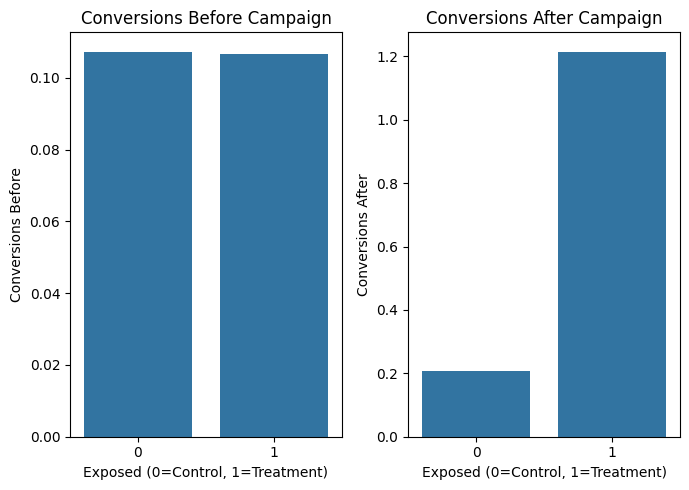

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the number of conversions before and after the campaign for treatment and control groups
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='exposed', y='conversions_before', data=data, errorbar=None)
plt.title('Conversions Before Campaign')
plt.xlabel('Exposed (0=Control, 1=Treatment)')
plt.ylabel('Conversions Before')

plt.subplot(1, 2, 2)
sns.barplot(x='exposed', y='conversions_after', data=data, errorbar=None)
plt.title('Conversions After Campaign')
plt.xlabel('Exposed (0=Control, 1=Treatment)')
plt.ylabel('Conversions After')

plt.tight_layout()
plt.show()


# **Data Preprocessing and EDA**

In [ ]:
# Calculate differences
data['clicks_diff'] = data['clicks_after'] - data['clicks_before']
data['conversions_diff'] = data['conversions_after'] - data['conversions_before']


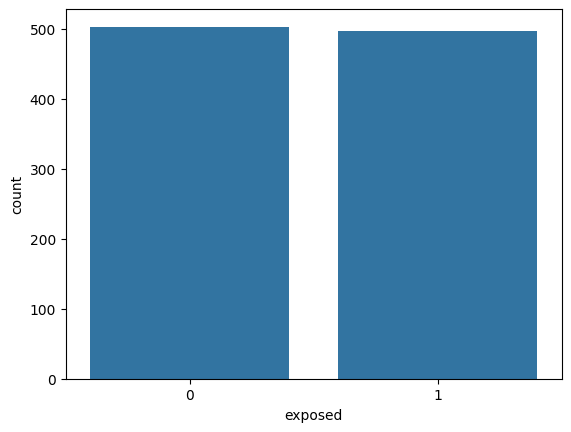

In [ ]:
# Let's see how many users has exposed to the Marketing Campaign

sns.countplot(x='exposed', data=data)
plt.show()

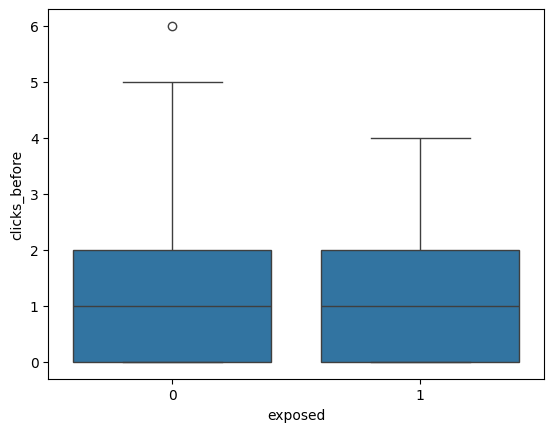

In [ ]:
# Identify the difference between exposed for clicks before

sns.boxplot(x='exposed', y='clicks_before', data=data)
plt.show()

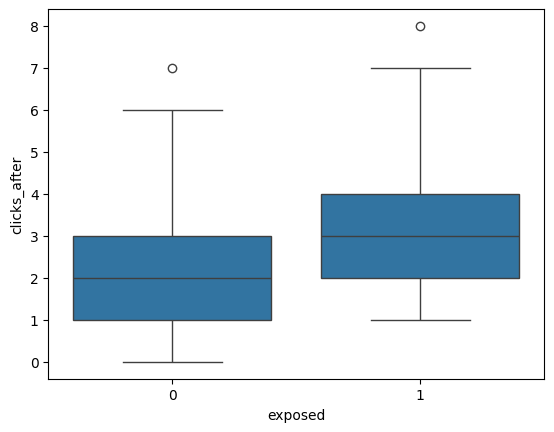

In [ ]:
# Identify the difference between exposed conversion rate and not exposed conversion rate

sns.boxplot(x='exposed', y='clicks_after', data=data)
plt.show()

**The mean of two groups is very close, let's perform test to see if these two group are statistically significant**

In [ ]:
from scipy import stats

# Perform two-sample t-test on clicks_after for treatment and control groups
t_stat, p_val = stats.ttest_ind(data[data['exposed'] == 1]['clicks_after'], data[data['exposed'] == 0]['clicks_after'])

print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: 10.417919035094942, P-value: 3.3921375693433e-24


In [ ]:
t_stat, p_val

(10.417919035094942, 3.3921375693433e-24)

In [ ]:
# Calculate the change in clicks
data['clicks_change'] = data['clicks_after'] - data['clicks_before']

# Perform two-sample t-test on clicks_change for treatment and control groups
t_stat_2, p_val_2 = stats.ttest_ind(data[data['exposed'] == 1]['clicks_change'], data[data['exposed'] == 0]['clicks_change'])

print(f"T-statistic: {t_stat_2}, P-value: {p_val_2}")


T-statistic: 15.833862527754906, P-value: 1.5163391122126406e-50


**We have an evidence to say that the effect is not by chance. There is a significant improvement in the number of clicks after the Campaign. But, how do we support this, afterall we've generated our own data.**


**Hang tight, we are diving into some of the key concepts shortly.**

**Propensity Score Matching (PSM)**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Fit logistic regression for propensity score
logit = LogisticRegression()
logit.fit(data[['clicks_before', 'conversions_before']], data['exposed'])
data['propensity_score'] = logit.predict_proba(data[['clicks_before', 'conversions_before']])[:, 1]


In [ ]:
# Split data into treatment and control groups
treatment = data[data['exposed'] == 1]
control = data[data['exposed'] == 0]

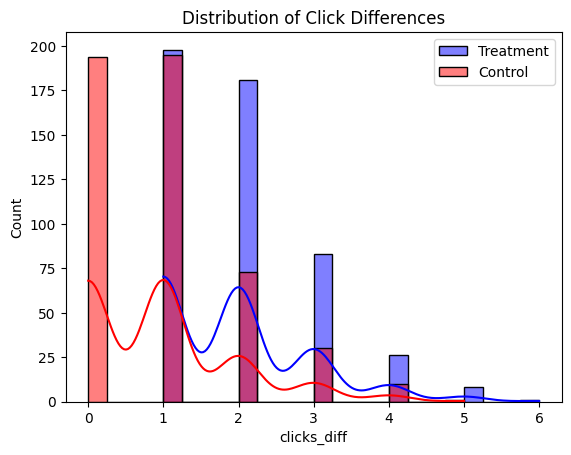

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize engagement metrics
sns.histplot(treatment['clicks_diff'], kde=True, color='blue', label='Treatment')
sns.histplot(control['clicks_diff'], kde=True, color='red', label='Control')
plt.legend()
plt.title('Distribution of Click Differences')
plt.show()


In [ ]:

# Match treatment and control users
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treatment[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Combine matched data
matched_data = pd.concat([treatment, matched_control])
print(matched_data.head())

   user_id  exposed  clicks_before  clicks_after  conversions_before  \
1        2        1              2             5                   0   
2        3        1              2             4                   0   
3        4        1              1             3                   0   
7        8        1              2             4                   1   
8        9        1              1             2                   0   

   conversions_after  clicks_diff  conversions_diff  clicks_change  \
1                  1            3                 1              3   
2                  2            2                 2              2   
3                  1            2                 1              2   
7                  2            2                 1              2   
8                  1            1                 1              1   

   propensity_score  
1          0.479840  
2          0.479840  
3          0.497724  
7          0.478807  
8          0.497724  


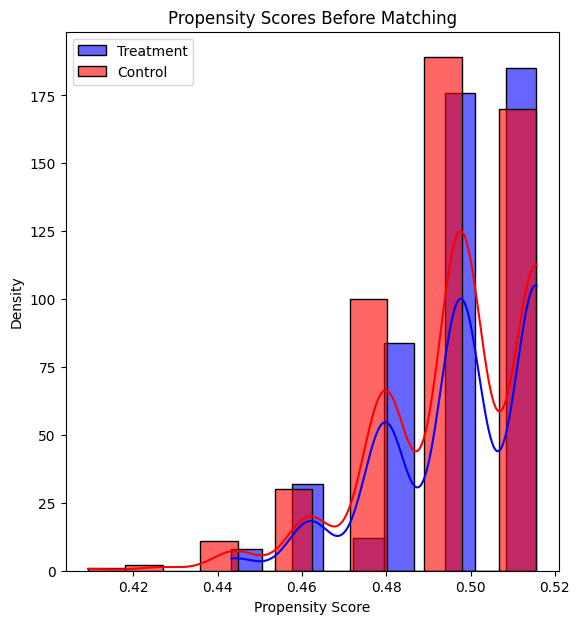

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot propensity scores before matching
plt.subplot(1, 2, 1)
sns.histplot(treatment['propensity_score'], color='blue', label='Treatment', kde=True, alpha=0.6)
sns.histplot(control['propensity_score'], color='red', label='Control', kde=True, alpha=0.6)
plt.title('Propensity Scores Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()


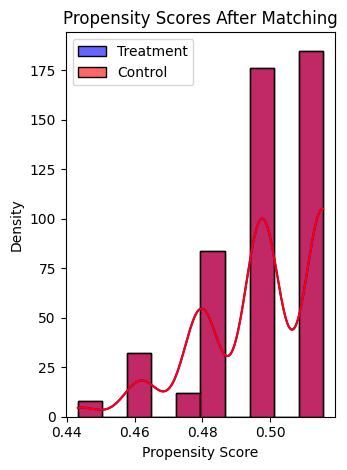

In [ ]:

# Plot propensity scores after matching
plt.subplot(1, 2, 2)
sns.histplot(matched_data[matched_data['exposed'] == 1]['propensity_score'], color='blue', label='Treatment', kde=True, alpha=0.6)
sns.histplot(matched_data[matched_data['exposed'] == 0]['propensity_score'], color='red', label='Control', kde=True, alpha=0.6)
plt.title('Propensity Scores After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()



# **Difference-in-Differences (DiD) Analysis**

In [ ]:
# Calculate DiD
did_clicks = (treatment['clicks_diff'].mean() - matched_control['clicks_diff'].mean())
did_conversions = (treatment['conversions_diff'].mean() - matched_control['conversions_diff'].mean())

print(f'DiD Estimate for Clicks: {did_clicks}')
print(f'DiD Estimate for Conversions: {did_conversions}')


DiD Estimate for Clicks: 1.1126760563380282
DiD Estimate for Conversions: 0.9396378269617707
